In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
# import libraries and packages 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, plot_confusion_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../input/d/laotse/credit-risk-dataset/credit_risk_dataset.csv")

In [5]:
# display total non-null records and column type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
# display some stats value of numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


<AxesSubplot:>

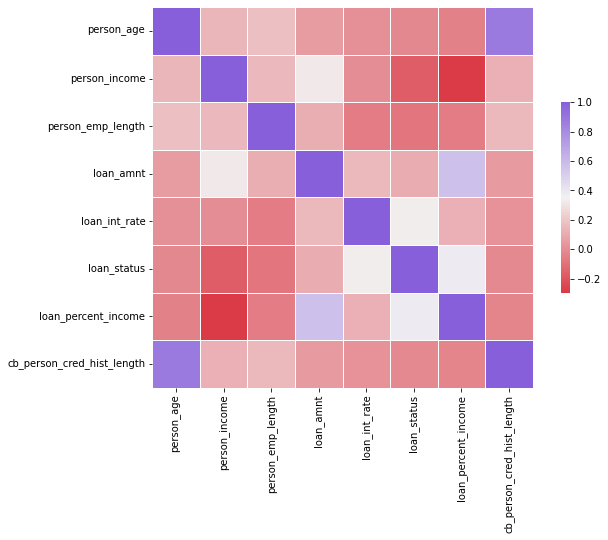

In [85]:
corr = df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

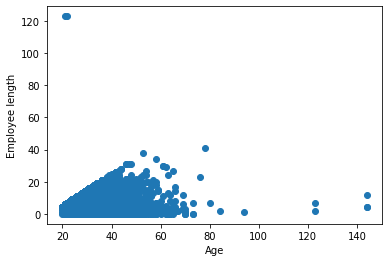

<Figure size 960x800 with 0 Axes>

In [8]:
plt.scatter("person_age", 'person_emp_length', data=df)
plt.xlabel('Age')
plt.ylabel('Employee length')
plt.figure(figsize=(12, 10), dpi=80)
plt.show()

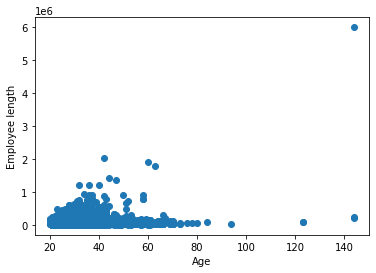

<Figure size 960x800 with 0 Axes>

In [9]:
plt.scatter("person_age", 'person_income', data=df)
plt.xlabel('Age')
plt.ylabel('Employee length')
plt.figure(figsize=(12, 10), dpi=80)
plt.show()

In [13]:
# Remove outlier on original and version 2 (add more attribute) dataset
df = df[df["person_age"] < 80]
df = df[df["person_income"] < 3000000]
df = df[(df["person_emp_length"] < 100) | (df["person_emp_length"].isnull())]
df.shape

(32571, 12)

In [14]:
# reset index in dataframe for running algorithm
df.reset_index(drop=True, inplace=True)

In [15]:
# split data to features and labels
features = df.drop(columns=["loan_status"], axis=1)
labels = df["loan_status"]

<BarContainer object of 2 artists>

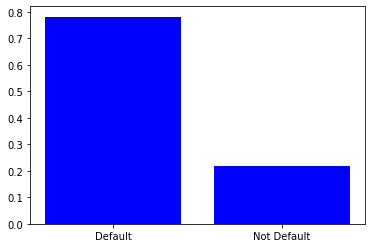

In [16]:
label_dist = list(labels.value_counts() / len(labels))
plt.bar(["Default", "Not Default"], label_dist, color="blue")

In [18]:
# get column name for transform data
categorical = list(features.select_dtypes(include="object"))
numerical = list(features.select_dtypes(exclude="object"))

In [23]:
# Pipeline
categorical_pipe = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

numerical_scaler_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer([
    ("cat", categorical_pipe , categorical),
    ("num", numerical_pipeline, numerical)
])

preprocessor_with_scaler = ColumnTransformer([
    ("cat", categorical_pipe , categorical),
    ("num", numerical_scaler_pipe, numerical)
])

In [60]:
def testing(model, x, y):
    y_pred = model.predict(x)
    precision = precision_score(y, y_pred, average=None)
    recall = recall_score(y, y_pred, average=None)
    f1 = f1_score(y, y_pred, average=None)
    print(classification_report(y, y_pred))
    return {"precision": precision, "recall": recall, "f1": f1}

In [20]:
# Split train data and test data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [21]:
y_test.value_counts()

0    5081
1    1434
Name: loan_status, dtype: int64

In [24]:
# KNN Algorithm
KNN_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", KNeighborsClassifier()),
])

param = {
    'model__n_neighbors' : [50, 75, 100, 125, 150],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2, 3]
}
gridsearch_knn = GridSearchCV(estimator = KNN_pipeline, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [25]:
gridsearch_knn.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   54.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file']),
                                                                        ('num',
                               

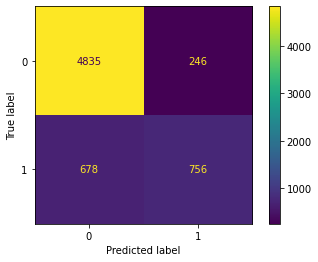

In [58]:
plot_confusion_matrix(gridsearch_knn, x_test, y_test)

In [61]:
print(gridsearch_knn.best_estimator_["model"])
print("Best f1 score data:", gridsearch_knn.best_score_)
knn_scores = testing(gridsearch_knn, x_test, y_test)

KNeighborsClassifier(n_neighbors=50, p=1, weights='distance')
Best f1 score data: 0.6056747887640205
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5081
           1       0.75      0.53      0.62      1434

    accuracy                           0.86      6515
   macro avg       0.82      0.74      0.77      6515
weighted avg       0.85      0.86      0.85      6515



In [29]:
# Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor_with_scaler),
    ("model", LogisticRegression(class_weight="balanced", tol=1e-5)),
])

param = {
    'model__C': [0.01, 0.1, 1, 10, 50, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

gridsearch_log_reg = GridSearchCV(estimator = log_reg_pipeline, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.


In [30]:
gridsearch_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file']),
                                                                        ('num',
                               

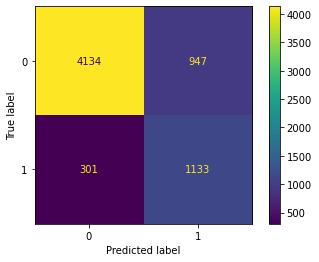

In [59]:
plot_confusion_matrix(gridsearch_log_reg, x_test, y_test)

In [63]:
print(gridsearch_log_reg.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_log_reg.best_score_)
log_reg_scores = testing(gridsearch_log_reg, x_test, y_test)

LogisticRegression(C=100, class_weight='balanced', penalty='l1',
                   solver='liblinear', tol=1e-05)
Best f1 score for data: 0.6395920948572703
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5081
           1       0.54      0.79      0.64      1434

    accuracy                           0.81      6515
   macro avg       0.74      0.80      0.76      6515
weighted avg       0.85      0.81      0.82      6515



In [35]:
pipeline_svm = Pipeline([
    ("preprocessor", preprocessor_with_scaler),
    ("model", SVC(class_weight="balanced")),
])

param = [
    {"model__kernel": ["rbf"], "model__gamma": [0.01, 0.1, 1, 10, 100], "model__C": [0.01, 0.1, 1, 10, 100]},
    {"model__kernel": ["linear"], "model__C": [0.01, 0.1, 1, 10, 100]},
    {"model__kernel": ["poly"], "model__C": [0.01, 0.1, 1, 10, 100], "model__degree": [2, 3, 4]}
]

gridsearch_svm = GridSearchCV(estimator = pipeline_svm, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [36]:
gridsearch_svm.fit(x_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 68.0min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 89.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file']),
                                                                        ('num',
                                

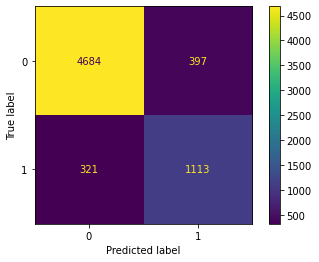

In [64]:
plot_confusion_matrix(gridsearch_svm, x_test, y_test)

In [66]:
print(gridsearch_svm.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_svm.best_score_)
svm_scores = testing(gridsearch_svm, x_test, y_test)

SVC(C=10, class_weight='balanced', gamma=0.1)
Best f1 score for data: 0.7508334735859986
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5081
           1       0.74      0.78      0.76      1434

    accuracy                           0.89      6515
   macro avg       0.84      0.85      0.84      6515
weighted avg       0.89      0.89      0.89      6515



In [39]:
pipeline_randomforest = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced")),
])

param = {
    "model__bootstrap": [True, False],
    'model__max_depth': [15, 25, 35, None],
    'model__max_features': [None, "sqrt"],
    'model__n_estimators': [50, 100, 150],
    "model__criterion": ["gini", "entropy"]
}
gridsearch_randomforest = GridSearchCV(estimator = pipeline_randomforest, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [40]:
gridsearch_randomforest.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 24.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file']),
                                                                        ('num',
                                

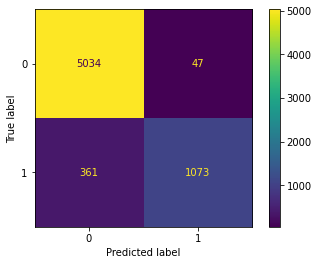

In [65]:
plot_confusion_matrix(gridsearch_randomforest, x_test, y_test)

In [67]:
print(gridsearch_randomforest.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_randomforest.best_score_)
randomforest_scores = testing(gridsearch_randomforest, x_test, y_test)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=25, max_features='sqrt',
                       n_estimators=150)
Best f1 score for data: 0.8199870142189514
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5081
           1       0.96      0.75      0.84      1434

    accuracy                           0.94      6515
   macro avg       0.95      0.87      0.90      6515
weighted avg       0.94      0.94      0.93      6515



In [44]:
pipeline_adaboost = Pipeline([
    ("preprocessor", preprocessor),
    ("model", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight="balanced"))),
])

param = {
    "model__n_estimators": [75, 100, 125, 150],
    "model__base_estimator__max_depth": [1, 2, 3, 4, 5, 6],
    "model__base_estimator__criterion": ["gini", "entropy"]
}


gridsearch_adaboost = GridSearchCV(estimator = pipeline_adaboost, # algorithm using
                        param_grid = param, # param for search best parameters
                        scoring = 'f1', # metric for kfold validation and choose best estimator
                        cv = 5,  # num fold using in kfold validation
                        verbose = 1, # print complete training with gridsearch
                        n_jobs = -1) # using all cpu core.

In [46]:
gridsearch_adaboost.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['person_home_ownership',
                                                                          'loan_intent',
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file']),
                                                                        ('num',
                                

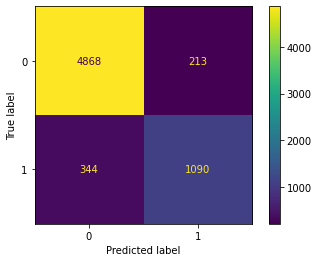

In [68]:
plot_confusion_matrix(gridsearch_adaboost, x_test, y_test)

In [69]:
print(gridsearch_adaboost.best_estimator_["model"])
print("Best f1 score for data:", gridsearch_adaboost.best_score_)
adaboost_scores = testing(gridsearch_adaboost, x_test, y_test)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=6),
                   n_estimators=150)
Best f1 score for data: 0.7814433340779813
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5081
           1       0.84      0.76      0.80      1434

    accuracy                           0.91      6515
   macro avg       0.89      0.86      0.87      6515
weighted avg       0.91      0.91      0.91      6515



In [72]:
model_names = ['KNN', 'LogReg', 'SVM', 'RF', 'Ada']
list_scores = [knn_scores, log_reg_scores, svm_scores, randomforest_scores, adaboost_scores]
avg_precision = [np.mean(x["precision"]) for x in list_scores]
avg_recall = [np.mean(x["recall"]) for x in list_scores]
avg_f1 = [np.mean(x["f1"]) for x in list_scores]

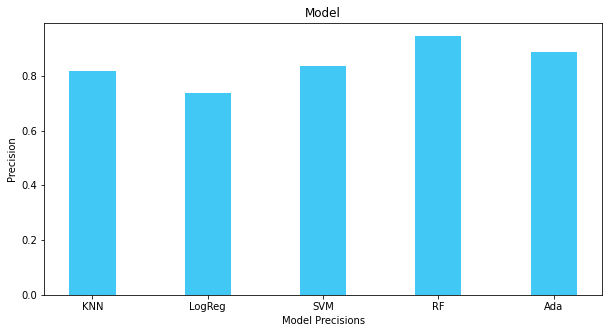

In [78]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_precision, color ='#42c8f5', width = 0.4)
plt.xlabel("Model Precisions")
plt.ylabel("Precision")
plt.title("Model")
plt.show()

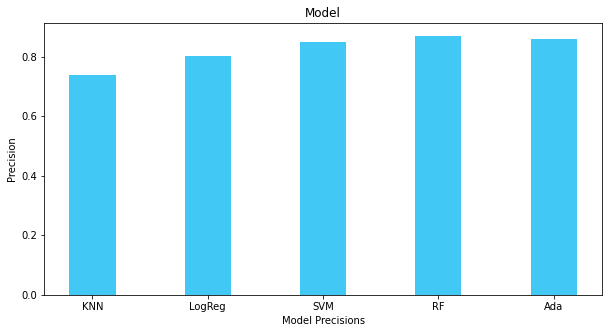

In [80]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_recall, color ='#42c8f5', width = 0.4)
plt.xlabel("Model Precisions")
plt.ylabel("Precision")
plt.title("Model")
plt.show()

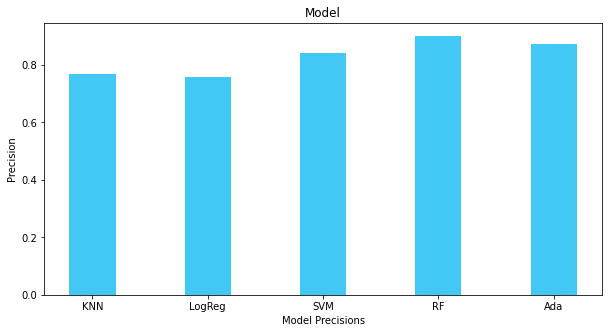

In [83]:
fig = plt.figure(figsize = (10, 5))
plt.bar(model_names, avg_f1, color ='#42c8f5', width = 0.4)
plt.xlabel("Model Precisions")
plt.ylabel("Precision")
plt.title("Model")
plt.show()